# Introductory Pixel/Object Extraction

In this tutorial we are going to cover an introductory object detection and extraction example. 

We will use a basic approach. Thus, we will not use any advanced statistics/machine learning. 

But it will require stitching together quite a lot of content which, so far, we have used in smaller problems. 

Here, the tutorial will go one step at a time, breaking down the method line-by-line. 

In general, we will:

1. Import a multiband image.
2. View this multiband image, to inspect the asset we are working with.
3. Load in the specific single band layers that we need here (e.g., rgb + near-infrared).
4. Create a normalized water index to help identify areas that we will want to extract.
5. Convert from raster coordinates to geographic coordinates.
6. Export our shapefiles. 

We have already covered 1, 2, 3 and 6 in previous tutorials. 

However, steps 4 and 5 will introduce some new, more complicated concepts for you.

## Spectral Indices

For those of you already taking other remote sensing classes, you will be aware of the wide array of different spectral indices available to us for use in pixel extraction activities. 

For example, see the 'awesome list of spectral indices' here:

https://github.com/awesome-spectral-indices/awesome-spectral-indices

Today we will consider extracting areas of water.


## Normalized Difference Water Index (NDWI)

Using a Normalized Difference Water Index (NDWI) (McFeeters, 1996) we will use the green and NIR bands to estimate water bodies, like so:

- NDWI = ( (green - nir) / (green + nir) )


Then we will extract this data to a shapefile. 

The learning outcomes will include:

- Image visualization basics.
- Introductory pixel identification/object extraction in satellite imagery.
- Conversion of pixels to shapes and extraction. 


## Import and View a Multi-band Image
Let us first import and inspect an image we will use for this tutorial. This is a quicker way than loading each individual band separately.  

We need to import a few packages, all of which we have covered before:

In [1]:
# Example
import rasterio
from rasterio.plot import show
from rasterio.features import shapes
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

We can use one of the pre-existing small images within the satellite image analysis repository. 

For example, for the Shenandoah River, in the Shenandoah Valley. 

See the file 'shenandoah_valley.tif' in the `notebooks/files` folder.

We can load this image in to view as follows (which should not be new content by now):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


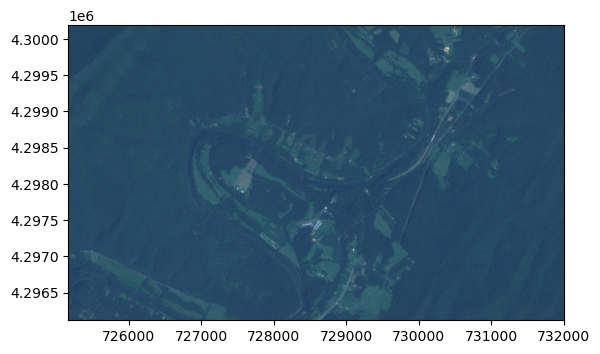

<AxesSubplot:>

In [2]:
# Example
# Open our image as a rasterio object
my_raster_image = rasterio.open('files/shenandoah_valley.tif')

## Planet PSScene image: https://developers.planet.com/docs/data/psscene/
## Order is blue, green, red, infrared
## Thus here for a red-green-blue true color composite, we reorder as 3,2,1.
## Also, scaling is similar to matplotlib, so values need to be between 0-1, thus we divide by 10,000.
rasterio.plot.show(
    my_raster_image.read([3,2,1]) / 10000, 
    transform=my_raster_image.transform
)

## Load Individual Bands

Next, we need to load in our mult-band layers. 

We will need these as individual variables, to allow us to specify our desired spectral index, and then undertake the actual pixel/image extraction part.

These can be separated out as follows (as we did in previous classes):

In [3]:
# Example
## Planet PSScene image: https://developers.planet.com/docs/data/psscene/
## Order is blue, green, red, infrared
## Thus here for a red-green-blue true color composite, we reorder as 3,2,1.
red = np.float32(my_raster_image.read(3))
green = np.float32(my_raster_image.read(2))
blue = np.float32(my_raster_image.read(1))
nir = np.float32(my_raster_image.read(4))
nir

array([[6892., 6810., 6809., ..., 7315., 7118., 6978.],
       [6755., 6684., 6688., ..., 6734., 6870., 6982.],
       [6809., 6672., 6647., ..., 6452., 6755., 6930.],
       ...,
       [6731., 7136., 7312., ..., 7225., 7076., 6778.],
       [6829., 7092., 7498., ..., 6757., 6554., 6476.],
       [6493., 6616., 7284., ..., 6168., 6147., 6304.]], dtype=float32)

From here, the aim is to **extract certain pixels and not others**, based on the underlying values, given our **NDWI specification**.

Therefore, we will need a new array in which we will place new values. 

This array will contain 1 for values we want, and 0 for values we do not want. And therefore resembles our own manually constructed mask. 

We can call this mask layer `water_index` (as we are going to extract water features), for example:

In [4]:
# Example
# Create a new empty numpy array of zeros using np.zeros().
# We just need to give this function the correct dimensions, thus, we use nir.shape
print(nir.shape)
water_index = np.zeros(nir.shape)
water_index

(1359, 2281)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Create Our Normalized Water Index  

Next, we will estimate our NDWI. 

You can evaluate the content on this page for a bit of background:

https://developers.planet.com/docs/planetschool/satellite-imagery/

*...an image contains some combination of bands, or data “layers”, that **represent each of the different wavelengths of light recorded by the sensor**. Planet’s satellites record red, green, blue, and near-infrared (NIR) light reflecting off the ground. Even though our eyes do not see it, near-infrared (NIR) light provides extremely helpful information! Our RapidEye images capture NIR as well as red edge information, which falls between "pure" red and NIR. People are most familiar with RGB images, because that’s what we see out in the world.*

Importantly:

*...chlorophyll reflects a lot of near-infrared (NIR) light, which means it’s useful for highlighting plants. **Water absorbs NIR light**, so it’s easy to distinguish green water from green plants.*

As water absorbs NIR light, we can use this to our advantage to specify our NDWI as follows: 

- NDWI = (
    (green - nir) / 
    (green + nir)
)

We can populate our `water_index` mask layer with the values resulting from this NDWI specification.

In [5]:
# Example
# Create a new empty numpy array of zeros.
water_index = np.zeros(nir.shape)

# Now let us estimate our NDWI values 
water_index = ((green-nir)/(green+nir))
water_index

array([[-0.4124398 , -0.40891692, -0.40696353, ..., -0.43220752,
        -0.41920048, -0.421326  ],
       [-0.40407398, -0.40258107, -0.40062827, ..., -0.4020404 ,
        -0.40605813, -0.42664486],
       [-0.39901376, -0.40182793, -0.400843  , ..., -0.38991815,
        -0.40714508, -0.42695355],
       ...,
       [-0.39806834, -0.41153198, -0.4187039 , ..., -0.43738186,
        -0.43137452, -0.41414562],
       [-0.41095042, -0.4117647 , -0.42805448, ..., -0.4093232 ,
        -0.41052404, -0.40127665],
       [-0.39739588, -0.39489773, -0.42349032, ..., -0.37878618,
        -0.39356154, -0.40229118]], dtype=float32)

We can interpret this as the higher the value, the larger the propability of each pixel being a water body. 

Therefore, values over zero can be allocated 1 (most likely water).

And values below zero can be allocated 0 (most likely not water).

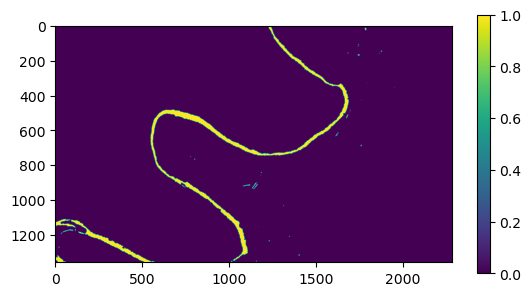

In [6]:
# Example
# Create a new empty numpy array of zeros.
water_index = np.zeros(nir.shape)

# Now let us estimate our NDWI values 
water_index = ((green-nir)/(green+nir))

# Allocate final values to our water index
# This is a conditional reassignment, so we allocate the value to the right hand of the equals,
# If the pixel matches the condition in the square parantheses
water_index[(water_index > 0)] = 1
water_index[(water_index <= 0)] = 0

# Example
plt.imshow(water_index)
plt.colorbar(shrink=0.7)

Finally, we will need to convert our `water_index` array to a float32 data type, before extracting geospatial objects:

In [7]:
# Example
# Convert to float32
water_index = water_index.astype('float32')
water_index

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Finally, we can convert our data into actual shapes which we can then use. 

See the `shapes` function that we use below, from the `rasterio` package:

https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html#rasterio.features.shapes

Which enables us to **"Get shapes and values of connected regions in a dataset or array."**

These are provided in the geojson format, which you should know already. 

In [16]:
# Example
# Now convert the numpy array to geojson
my_shapes = shapes(water_index)
my_shapes

<generator object shapes at 0x000001EACEFD97B0>

## Converting from Raster to Geographic Coordinates

As our coordinates are in raster pixel space, we are going to need to convert them into geographic coordinates. 

You will be able to reuse this function whenever you please. Let us define it first.

And now comes the tricky part. 

For every shape in our `my_shapes` data we are going to convert the coordinates using the function `rasterio.xy()`, and then write the data to a geojson LineString. 

Finally, we will append each shape to a list. 

In [22]:
# Example
my_shapes = shapes(water_index)

# Create an empty dataframe 
output = []

# Iterate over our shapes
for river_shape in my_shapes:

    # Index into our shape to get the coordinates
    # This indexing means we access:
    # - The first list in `river_shape` via [0]
    # - The coordinates values in the dictionary via ['coordinates']
    # - The first list in `coordinates` via [0]
    coords = river_shape[0]['coordinates'][0]

    # Transform the raster coordinates into geographic coordinates
    geographic_coords = [my_raster_image.xy(pair[1],pair[0]) for pair in coords]

    # Specify a geojson with our transformed coordinates
    output.append({
        'geometry' : {
            'type':'LineString',
            'coordinates': geographic_coords
            },
        'properties': {},
    }) 
        
print('Output contains {} shapes'.format(len(output)))

Output contains 63 shapes


## Export Shapefiles

Next, we can convert our list of dictionaries (where each dict is a geojson structure), into a geopandas dataframe using the function `gpd.GeoDataFrame.from_features()`. 

Importantly, we specify our coordinate reference system as per the original image (`epsg:32617`).

Then we can write out the final shapefiles via the `to_file()` function. 

In [23]:
# Example
data_to_write = gpd.GeoDataFrame.from_features(output, crs='epsg:32617')

data_to_write.to_file('shapes/river_shape.shp')

C:\Users\eoughton\Anaconda3\envs\test3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Exercise

- Find and download a clear multi-band image for Great Falls Park. 
- Clip to a small area, ideally showing the area around Olmsted Island or Rocky Island. 
- Extract the water areas, so that you have a clear shapefile for Great Falls.
- Overlay the shapes on the original image.
- Critically review this process and what you found (~200 words). 
- Submit for the next assignment. 